In [32]:
import numpy as np
import matplotlib.pyplot as plt

## Modular implementation of vanilla neural network

Consider the single layer neural network given by 
$$x \rightarrow z=Wx+b\rightarrow a=f(z)\rightarrow l(a,y)$$
Where $x\in \mathbb{R}^p$, $W\in \mathbb{R}^{n\times p}$ and $b\in \mathbb{R}^{p}$, and $l$ denote the loss function. To perform back-propagation, we use the formula that
$$\frac{\partial l}{\partial W}=(f'(z)\odot l'(a,y))\cdot x^T$$
$$\frac{\partial l}{\partial b}=(f'(z)\odot l'(a,y))$$
Where $\odot$ represent component-wise multiplication

In [75]:
class Dense:
    
    def __init__(self, 
                 input_dim: int, 
                 output_dim: int, 
                 activation: callable, 
                 derivative: callable, 
                 learning_rate=0.01,
                 vectorize=True,
                 initialize_variance=0.01):
        
        self.W = np.random.normal(loc=0, scale=initialize_variance, size=(output_dim, input_dim))
        self.b = np.random.normal(loc=0, scale=initialize_variance, size=(output_dim, 1))
        self.x = 0
        self.z = 0
        self.a = 0
        self.lr = learning_rate
        self.activation = activation
        self.derivative = derivative
        if vectorize:
            self.activation = np.vectorize(self.activation)
            self.derivative = np.vectorize(self.derivative)
        
        
    def forward(self, x):
        self.x = x.reshape(-1, 1)
        self.z = np.dot(self.W, self.x) + self.b
        self.a = self.activation(self.z)
        return self.a
    
    def backward(self, grad):
        grad = grad * self.derivative(self.z)
        grad_w = np.dot(grad, self.x.T)
        grad_b = grad
        self.W -= self.lr * grad_w
        self.b -= self.lr * grad_b
        grad = np.dot(self.W.T, grad)
        return grad

In [76]:
## Test the output of forward propagation
act = lambda x: x ** 2
der = lambda x: 2 * x
n = Dense(3, 5, act, der, 0.1)
x = np.random.normal(loc=0, scale=1, size=(3, ))
a = n.forward(x)
print(f"Shape after forward propagation: {a.shape}")
print(a)

Shape after forward propagation: (5, 1)
[[2.23405788e-05]
 [7.99563534e-05]
 [4.31979307e-04]
 [4.60636646e-05]
 [3.50220775e-04]]


In [77]:
## Test the output of backward propagation
act = lambda x: x ** 2
der = lambda x: 2 * x
n = Dense(3, 5, act, der, 0.01)
x = np.random.normal(loc=0, scale=1, size=(3, 1))
a = n.forward(x)
y = np.random.normal(loc=0, scale=1, size=(5, 1))
b = n.backward(y)
print(f"Shape after forward propagation: {b.shape}")
print(b)

Shape after forward propagation: (3, 1)
[[ 0.00011657]
 [-0.00043605]
 [-0.00116022]]


## Training a dense neural network on MNIST dataset (without using batches)

In [78]:
from keras.datasets import mnist

In [79]:
from keras.utils import to_categorical

In [80]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_samples = 600
train_images = train_images[:train_samples, :]
train_labels = train_labels[:train_samples]

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Train images shape: (600, 28, 28)
Train labels shape: (600,)


In [81]:
train_images = train_images.reshape(train_images.shape[0], -1)

print("Train images shape:", train_images.shape)

Train images shape: (600, 784)


In [82]:
train_labels = to_categorical(train_labels, num_classes=10)
print("Train labels shape:", train_labels.shape)

Train labels shape: (600, 10)


In [83]:
train_images = train_images / 255

In [84]:
relu = lambda x: max(x, 0)
relu_prime = lambda x: 1 if x >= 0 else 0

In [85]:
def softmax(x):
    e_x = np.exp(x)
    return e_x / np.sum(e_x, axis=0)

def softmax_prime(x):
    e_x = np.exp(x)
    numerator = e_x * np.sum(e_x, axis=0) - np.exp(2 * x)
    return numerator / np.sum(e_x, axis=0) ** 2

In [13]:
def loss(y_true, y_pred):
    return np.sqrt(np.sum((y_true - y_pred) ** 2)) / len(y_true)

def loss_prime(y_true, y_pred):
    return 2 * (y_true - y_pred)

In [14]:
class Model:
    
    def __init__(self, input_dim):
        self.layer1 = Dense(input_dim, 32, relu, relu_prime)
        self.layer2 = Dense(32, 10, softmax, softmax_prime, vectorize=False)
        self.layers = [self.layer1, self.layer2]
        self.loss = loss
        self.loss_prime = loss_prime
        self.num_layers = len(self.layers)
        
    def run(self, x):
        for i in range(self.num_layers):
            x = self.layers[i].forward(x)
        return x
            
    def backprop(self, grad):
        for j in range(self.num_layers - 1, -1, -1):
            grad = self.layers[j].backward(grad)
        return grad
        
    def train(self, num_epochs, X, Y):
        num_samples = len(X)
        for epoch in range(num_epochs):
            avg_loss = 0
            for i in range(num_samples):
                x = X[i]
                y = Y[i].reshape(-1, 1)
                
                x = self.run(x)
                
                loss = self.loss(x, y)
                avg_loss += loss
                grad = self.loss_prime(x, y)
                
                grad = self.backprop(grad)
                    
            if epoch % 5 == 0:
                print(f"Loss at epoch {epoch}: {avg_loss / num_samples}")        
                print("-----------------------------------------------------------")
    
    def predict(self, X):
        num_samples = len(X)
        predictions = []
        for i in range(num_samples):
            x = X[i]
            result = self.run(x)
            predictions.append(np.argmax(result))
        return np.array(predictions)
            

In [16]:
model = Model(28 * 28)
model.train(70, train_images, train_labels)

Loss at epoch 0: 0.09463218012697366
-----------------------------------------------------------
Loss at epoch 5: 0.06012805077929425
-----------------------------------------------------------
Loss at epoch 10: 0.03200673601856607
-----------------------------------------------------------
Loss at epoch 15: 0.020710267164585582
-----------------------------------------------------------
Loss at epoch 20: 0.01551662224766179
-----------------------------------------------------------
Loss at epoch 25: 0.014855057638488154
-----------------------------------------------------------
Loss at epoch 30: 0.009073208120721678
-----------------------------------------------------------
Loss at epoch 35: 0.008291375041281168
-----------------------------------------------------------
Loss at epoch 40: 0.004862065010569293
-----------------------------------------------------------
Loss at epoch 45: 0.004187049592634399
-----------------------------------------------------------
Loss at epoch 50

In [17]:
test_samples = 10
test_X = test_images[:test_samples, :]
test_y = test_labels[:test_samples]
test_X = test_X.reshape(test_X.shape[0], -1)
test_X = test_X / 255
predictions = model.predict(test_X)

print(f"Shape of predictions: {predictions.shape}")
print(f"Predictions: {model.predict(test_X)}")
print(f"Ground truth: {test_y}")

Shape of predictions: (10,)
Predictions: [7 2 1 0 4 1 4 9 2 9]
Ground truth: [7 2 1 0 4 1 4 9 5 9]


In [18]:
test_samples = 1000
test_X = test_images[:test_samples, :]
test_y = test_labels[:test_samples]
test_X = test_X.reshape(test_X.shape[0], -1)
test_X = test_X / 255
predictions = model.predict(test_X)

predictions = model.predict(test_X)
accuracy = np.count_nonzero(predictions == test_y) * 100 / test_samples
print(f"Accuracy of the model is: {accuracy} %")

Accuracy of the model is: 82.0 %


## Training a dense neural network to approximate cosine function

In [149]:
def generate_data(k):
    x = 1 * np.random.rand(k)
    y = np.cos(x)
    return x, y

In [150]:
x_train, y_train = generate_data(60)

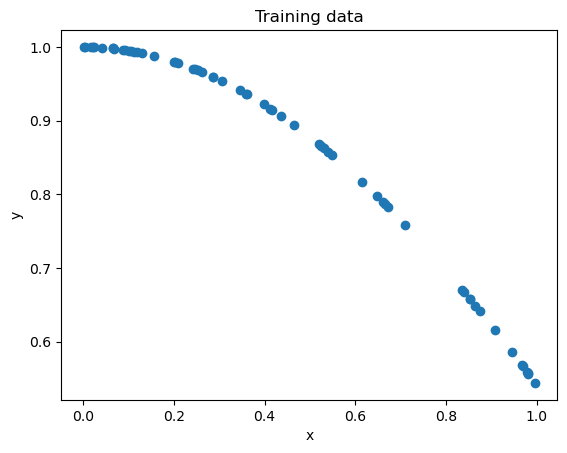

In [151]:
plt.scatter(x_train, y_train)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training data")
plt.show()

In [152]:
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

In [172]:
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 / (np.cosh(x) ** 2)

In [230]:
class Model:
    
    def __init__(self, input_dim):
        self.layer1 = Dense(input_dim, 32, tanh, tanh_prime, learning_rate=0.05, initialize_variance=0.1)
        self.layer2 = Dense(32, 1, tanh, tanh_prime, learning_rate=0.05, initialize_variance=0.1)
        self.layers = [self.layer1, self.layer2]
        self.loss = loss
        self.loss_prime = loss_prime
        self.num_layers = len(self.layers)
        
    def run(self, x):
        for i in range(self.num_layers):
            x = self.layers[i].forward(x)
#         print(f"Prediction: {self.layers[1].a}")
        return x
            
    def backprop(self, grad):
        for j in range(self.num_layers - 1, -1, -1):
            grad = self.layers[j].backward(grad)
        return grad
        
    def train(self, num_epochs, X, Y):
        num_samples = len(X)
        for epoch in range(num_epochs):
            avg_loss = 0
            for i in range(num_samples):
                x = X[i]
                y = Y[i]
                
                x = self.run(x)
                
                loss = self.loss(x, y)
                avg_loss += loss
                grad = self.loss_prime(x, y)
                
                grad = self.backprop(grad)
                    
            if epoch % 5 == 0:
                print(f"Loss at epoch {epoch}: {avg_loss / num_samples}")        
                print("-----------------------------------------------------------")
    
    def predict(self, X):
        num_samples = len(X)
        predictions = []
        for i in range(num_samples):
            x = X[i]
            result = self.run(x)
            predictions.append(result)
        return np.array(predictions).astype(float)
            

In [231]:
model = Model(1)
model.train(200, x_train, y_train)

Loss at epoch 0: 0.23695310516361728
-----------------------------------------------------------
Loss at epoch 5: 0.11617044461486613
-----------------------------------------------------------
Loss at epoch 10: 0.07978153595891962
-----------------------------------------------------------
Loss at epoch 15: 0.0488532691464914
-----------------------------------------------------------
Loss at epoch 20: 0.03213299792888102
-----------------------------------------------------------
Loss at epoch 25: 0.023722997436336348
-----------------------------------------------------------
Loss at epoch 30: 0.020285266323197357
-----------------------------------------------------------
Loss at epoch 35: 0.019223942472075477
-----------------------------------------------------------
Loss at epoch 40: 0.018674860226568155
-----------------------------------------------------------
Loss at epoch 45: 0.01839992135874057
-----------------------------------------------------------
Loss at epoch 50: 0

In [232]:
x_test, y_test = generate_data(50)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

predictions = model.predict(x_test)

In [233]:
predictions = predictions.reshape(50,)

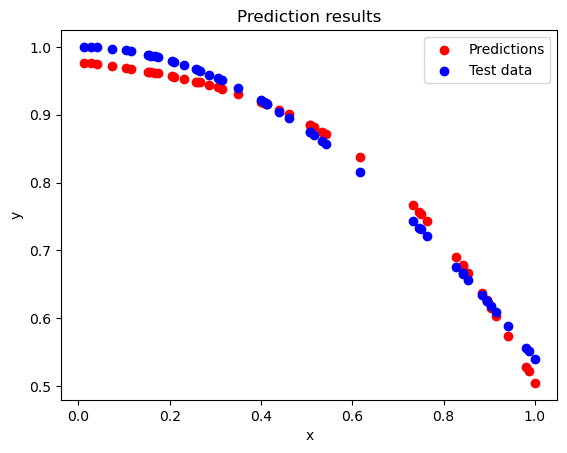

In [236]:
plt.scatter(x_test, predictions, color="red", label="Predictions")
plt.scatter(x_test, y_test, color="blue", label="Test data")
plt.title("Prediction results")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [235]:
print(f"The test loss is: {loss(predictions, y_test)}")

The test loss is: 0.21236047012563927
